In [1]:
import torch
torch.cuda.is_available()

True

build_dataset.py    kaggle_api.ipynb  README.md		    train_model.py
cloud_script.ipynb  model_backups     test
exploration	    packages	      training_history.png


In [37]:
!git pull https://github.com/Lolleeee/MIEEG

remote: Enumerating objects: 15, done.
remote: Counting objects: 100% (15/15), done.
remote: Compressing objects: 100% (1/1), done.
remote: Total 8 (delta 7), reused 8 (delta 7), pack-reused 0 (from 0)
Unpacking objects: 100% (8/8), 63.95 KiB | 1.56 MiB/s, done.
From https://github.com/Lolleeee/MIEEG
 * branch            HEAD       -> FETCH_HEAD
Updating f99f42b..b4cd4f5
Fast-forward
 kaggle_api.ipynb        | 852 +++++++++++++++++++++++++++++++++++++-----------
 packages/models/vqae.py | 121 +++----
 test/train_loop.py      |   9 +-
 3 files changed, 727 insertions(+), 255 deletions(-)


In [ ]:
!git clone https://github.com/Lolleeee/MIEEG
import os 
os.chdir("MIEEG")


Cloning into 'MIEEG'...
remote: Enumerating objects: 1016, done.
remote: Counting objects: 100% (167/167), done.
remote: Compressing objects: 100% (114/114), done.
remote: Total 1016 (delta 115), reused 95 (delta 53), pack-reused 849 (from 1)
Receiving objects: 100% (1016/1016), 38.88 MiB | 47.07 MiB/s, done.
Resolving deltas: 100% (667/667), done.


In [2]:
import numpy as np
matrix = np.array(
    [
        [None, "Fp1", None, "Fp2", None],
        ["F7", "F3", "Fz", "F4", "F8"],
        ["FC5", "FC1", "Cz", "FC2", "FC6"],
        ["T7", "C3", "CP1", "C4", "T8"],
        ["TP9", "CP5", "CP2", "CP6", "TP10"],
        ["P7", "P3", "Pz", "P4", "P8"],
        ["PO9", "O1", "Oz", "O2", "PO10"],
    ]
)

In [26]:
from packages.train.training import train_model
from packages.train.loss import CustomMSELoss, PerceptualLoss, CustomL1Loss
from packages.io.file_loader import get_data_loaders
import torch
import os

from packages.data_objects.dataset import TorchDataset, CustomTestDataset

dataset_path = "/kaggle/input/0-5subset-datanooverlap"
# Dummy training loop

dataset = TorchDataset(root_folder=dataset_path, chunk_size=25)

train_loader, val_loader, _ = get_data_loaders(dataset, sets_size={'train': 0.7, 'val': 0.3, 'test': 0.}, norm_axes=(0, 1, 5), batch_size = 128)
# norm_params = train_loader.dataset.dataset._norm_params

Calculating global parameters: 100%|██████████| 44/44 [00:23<00:00,  1.91it/s]

Calculated mean shape: torch.Size([1, 25, 7, 5, 1]), std shape: torch.Size([1, 25, 7, 5, 1])


6 0 ['Dim 0', 'Dim 1', 'Dim 2', 'Dim 3']


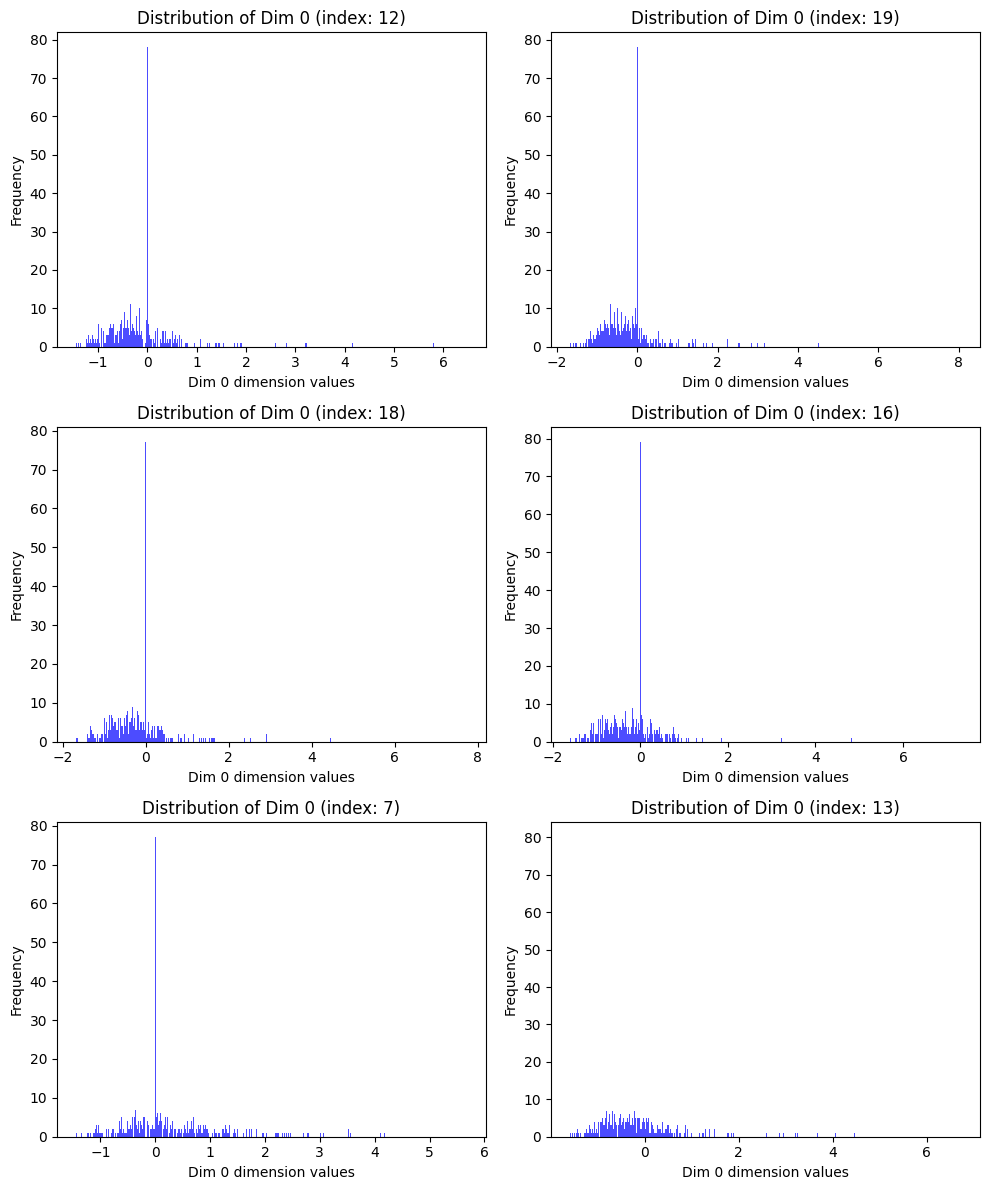

In [19]:

from packages.plotting.tensor_plots import plot_dimension_distribuitions
#train_loader.dataset.dataset._norm_params = norm_params
plot_dimension_distribuitions(next(iter(train_loader))[0, 0, ...])

In [25]:
import torch
import torch.nn as nn
import torch.nn.functional as F
class SequenceVQVAELoss(nn.Module):
    """
    Loss function for SequenceProcessor.
    Handles sequences of chunks.
    
    Usage:
        criterion = SequenceVQVAELoss(recon_loss_type='mse')
        
        # During training:
        chunks = ...  # (B, num_chunks, 25, 7, 5, 32)
        reconstruction, vq_loss, indices = seq_processor(chunks)
        loss = criterion(chunks, reconstruction, vq_loss)
    """
    def __init__(
        self,
        recon_loss_type='mse',
        recon_weight=1.0,
        perceptual_weight=0.1
    ):
        super().__init__()
        
        self.recon_loss_type = recon_loss_type
        self.recon_weight = recon_weight
        self.perceptual_weight = perceptual_weight
    
    def _perceptual_loss(self, x, x_recon):
        """Perceptual loss for sequence of chunks"""
        # Flatten sequence dimension for processing
        batch_size, num_chunks = x.shape[:2]
        x_flat = x.view(-1, *x.shape[2:])
        x_recon_flat = x_recon.view(-1, *x_recon.shape[2:])
        
        # Compute gradients
        def compute_gradients(tensor):
            dx = tensor[:, :, 1:, :, :] - tensor[:, :, :-1, :, :]
            dy = tensor[:, :, :, 1:, :] - tensor[:, :, :, :-1, :]
            dt = tensor[:, :, :, :, 1:] - tensor[:, :, :, :, :-1]
            return dx, dy, dt
        
        x_grads = compute_gradients(x_flat)
        recon_grads = compute_gradients(x_recon_flat)
        
        loss = sum(F.l1_loss(g1, g2) for g1, g2 in zip(x_grads, recon_grads))
        return loss / 3.0

    def forward(self, outputs, chunks):
        """
        Compute total loss for sequence.
        
        Args:
            chunks: Original chunks (B, num_chunks, 25, 7, 5, 32)
            chunks_recon: Reconstructed chunks (B, num_chunks, 25, 7, 5, 32)
            vq_loss: VQ commitment loss from model
            
        Returns:
            loss: Total loss (scalar)
        """
        chunks_recon, vq_loss, _= outputs
        # Reconstruction loss
        if self.recon_loss_type == 'mse':
            recon_loss = F.mse_loss(chunks_recon, chunks)
        elif self.recon_loss_type == 'l1':
            recon_loss = F.l1_loss(chunks_recon, chunks)
        elif self.recon_loss_type == 'perceptual':
            recon_loss = F.mse_loss(chunks_recon, chunks)
            perc_loss = self._perceptual_loss(chunks, chunks_recon)
            recon_loss = recon_loss + self.perceptual_weight * perc_loss
        else:
            raise ValueError(f"Unknown recon_loss_type: {self.recon_loss_type}")
        
        # Total loss
        total_loss = self.recon_weight * recon_loss + vq_loss
        print(f"Reconstruction Loss: {recon_loss.item():.4f}, VQ Loss: {vq_loss.item():.4f}, Total Loss: {total_loss.item():.4f}")
        return total_loss

In [27]:
optimizer = torch.optim.AdamW
from packages.models.vqae import SequenceProcessor, VQVAE
from packages.train.loss import VQVAELoss, SequenceVQVAELoss
model = SequenceProcessor(chunk_shape=(25, 7, 5, 25), embedding_dim=128, codebook_size=64)
mae = torch.nn.L1Loss
criterion = SequenceVQVAELoss(
    recon_loss_type='mse',
    recon_weight=1.0
)
config = {
    'lr': 1e-4,
    'weight_decay': 1e-3,
    'epochs': 50,
    #'EarlyStopping' : {'patience': 20, 'min_delta': 0.01},
    'BackupManager': {'backup_interval': 10, 'backup_path': './model_backups'},
    #'ReduceLROnPlateau': {'mode': 'min', 'patience': 5, 'factor': 0.0},
    'history_plot': {'plot_type': 'extended', 'save_path': './training_history'},
    'grad_clip': 1.0,
    'use_amp': False,
    #'grad_logging_interval' : 10,
    'asym_lr': None
}

model = train_model(model, train_loader=train_loader, val_loader=val_loader, loss_criterion=criterion, optimizer=optimizer, config=config, metrics={})

Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Training Batches:   0%|          | 0/44 [00:00<?, ?it/s]

[INFO] Train Loss: 1.1577
[INFO] Val Loss: 1.5540
[INFO] Best model saved at epoch 1 with metric 1.5540


Training Batches:   0%|          | 0/44 [00:00<?, ?it/s]

[INFO] Train Loss: 1.3017
[INFO] Val Loss: 1.3454
[INFO] Best model saved at epoch 2 with metric 1.3454


Training Batches:   0%|          | 0/44 [00:00<?, ?it/s]

[INFO] Train Loss: 1.3732
[INFO] Val Loss: 1.4818


Training Batches:   0%|          | 0/44 [00:00<?, ?it/s]

[INFO] Train Loss: 1.7254
[INFO] Val Loss: 2.1519


Training Batches:   0%|          | 0/44 [00:00<?, ?it/s]

[INFO] Train Loss: 1.9448
[INFO] Val Loss: 2.1380


Training Batches:   0%|          | 0/44 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [7]:
from packages.train.training import train_model
from packages.train.loss import CustomMSELoss, PerceptualLoss, CustomL1Loss
from packages.io.file_loader import get_data_loaders
import torch
import os

from packages.data_objects.dataset import TorchDataset, CustomTestDataset

dataset_path = "/kaggle/input/64nooverlap05"
# Dummy training loop

dataset = TorchDataset(root_folder=dataset_path)

train_loader, val_loader, _ = get_data_loaders(dataset, sets_size={'train': 0.7, 'val': 0.3}, norm_axes=(0, 4), batch_size = 64)


Calculating global parameters: 100%|██████████| 338/338 [00:46<00:00,  7.33it/s]

Calculated mean shape: torch.Size([25, 7, 5, 1]), std shape: torch.Size([25, 7, 5, 1])


In [ ]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model1 = VQVAE(input_spatial=(7, 5 ,64), embedding_dim=512, codebook_size=64)
model1.to(device)
for batch in train_loader:
    with torch.no_grad():
        batch = batch.to(device)
        x = batch
        z = model1.encoder(x)               # change to how you get pre-quant z
        z_flat = z.view(z.size(0), -1)
        z_std = z_flat.std(dim=1).mean().item()
        z_mean = z_flat.mean().item()

        x_std = x.view(x.size(0), -1).std(dim=1).mean().item()
        x_mean = x.view(x.size(0), -1).mean().item()

        print(f"Input Std: {x_std:.4f}, Mean: {x_mean:.4f} | Pre-Quantization Latent Std: {z_std:.4f}, Mean: {z_mean:.4f}")
        
        _, _, indices = model.vq(z)
        unique_codes = len(torch.unique(indices))
        print(f"Unique codes used: {unique_codes}/{model.vq.num_embeddings}")

NameError: name 'x' is not defined

In [34]:
for name, p in model.encoder.named_parameters():
    if p.grad is None:
        print(f"{name}: NO GRAD")
    else:
        print(f"{name}: grad norm {p.grad.norm().item():.3e}")

0.weight: grad norm 2.775e-02
1.weight: grad norm 1.177e-02
1.bias: grad norm 1.157e-02
3.weight: grad norm 1.507e-02
4.weight: grad norm 4.048e-03
4.bias: grad norm 5.888e-03
6.weight: grad norm 7.290e-03
7.weight: grad norm 3.294e-03
7.bias: grad norm 3.202e-03


In [9]:

optimizer = torch.optim.AdamW
from packages.models.vqae import SequenceProcessor, VQVAE
from packages.train.loss import VQVAELoss, SequenceVQVAELoss
model = VQVAE(input_spatial=(7, 5 ,64), embedding_dim=512, codebook_size=64)
mae = torch.nn.L1Loss
criterion = VQVAELoss(
    recon_loss_type='mse',
    recon_weight=1.0,
)
config = {
    'lr': 1e-3,
    'weight_decay': 1e-3,
    'epochs': 50,
    #'EarlyStopping' : {'patience': 20, 'min_delta': 0.01},
    'BackupManager': {'backup_interval': 10, 'backup_path': './model_backups'},
    #'ReduceLROnPlateau': {'mode': 'min', 'patience': 5, 'factor': 0.0},
    'history_plot': {'plot_type': 'extended', 'save_path': './training_history'},
    'grad_clip': 1.0,
    'use_amp': False,
    'grad_logging_interval' : None,
    'asym_lr': None
}

model = train_model(model, train_loader=train_loader, val_loader=val_loader, loss_criterion=criterion, optimizer=optimizer, config=config, metrics={})

Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Training Batches:   0%|          | 0/338 [00:00<?, ?it/s]

[INFO] Train Loss: 0.9217
[INFO] Val Loss: 0.9096
[INFO] Best model saved at epoch 1 with metric 0.9096


Training Batches:   0%|          | 0/338 [00:00<?, ?it/s]

[INFO] Train Loss: 0.9144
[INFO] Val Loss: 0.9095
[INFO] Best model saved at epoch 2 with metric 0.9095


Training Batches:   0%|          | 0/338 [00:00<?, ?it/s]

[INFO] Train Loss: 0.9143
[INFO] Val Loss: 0.9094
[INFO] Best model saved at epoch 3 with metric 0.9094


Training Batches:   0%|          | 0/338 [00:00<?, ?it/s]

[INFO] Train Loss: 0.9142
[INFO] Val Loss: 0.9094


Training Batches:   0%|          | 0/338 [00:00<?, ?it/s]

[INFO] Train Loss: 0.9143
[INFO] Val Loss: 0.9094
[INFO] Best model saved at epoch 5 with metric 0.9094


Training Batches:   0%|          | 0/338 [00:00<?, ?it/s]

[INFO] Train Loss: 0.9142
[INFO] Val Loss: 0.9095


Training Batches:   0%|          | 0/338 [00:00<?, ?it/s]

[INFO] Train Loss: 0.9142


KeyboardInterrupt: 

In [30]:
from packages.train.testing import autoencoder_test_plots
autoencoder_test_plots(model, val_loader, nsamples = 5)

torch.Size([7, 10, 25, 7, 5, 25])


/kaggle/working/MIEEG/packages/train/testing.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = torch.tensor(inputs).to(device)


TypeError: expected Tensor as element 0 in argument 0, but got tuple

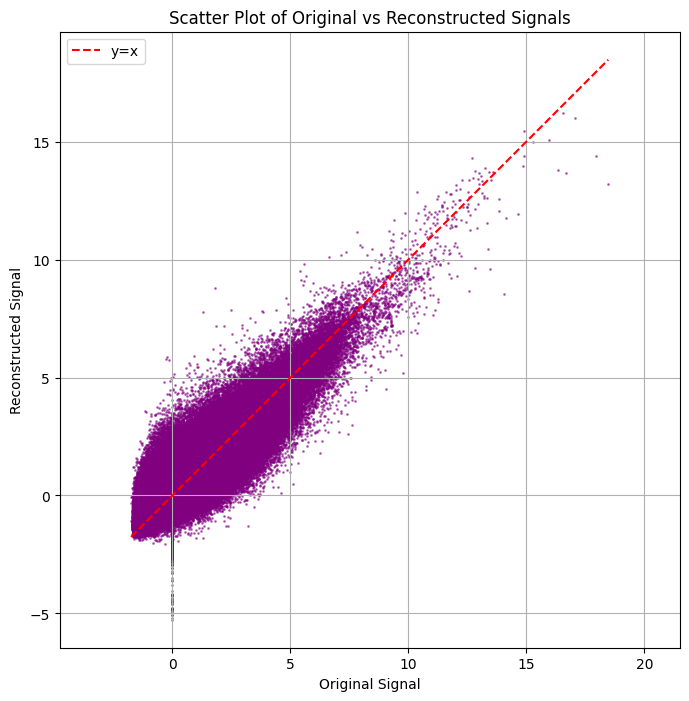

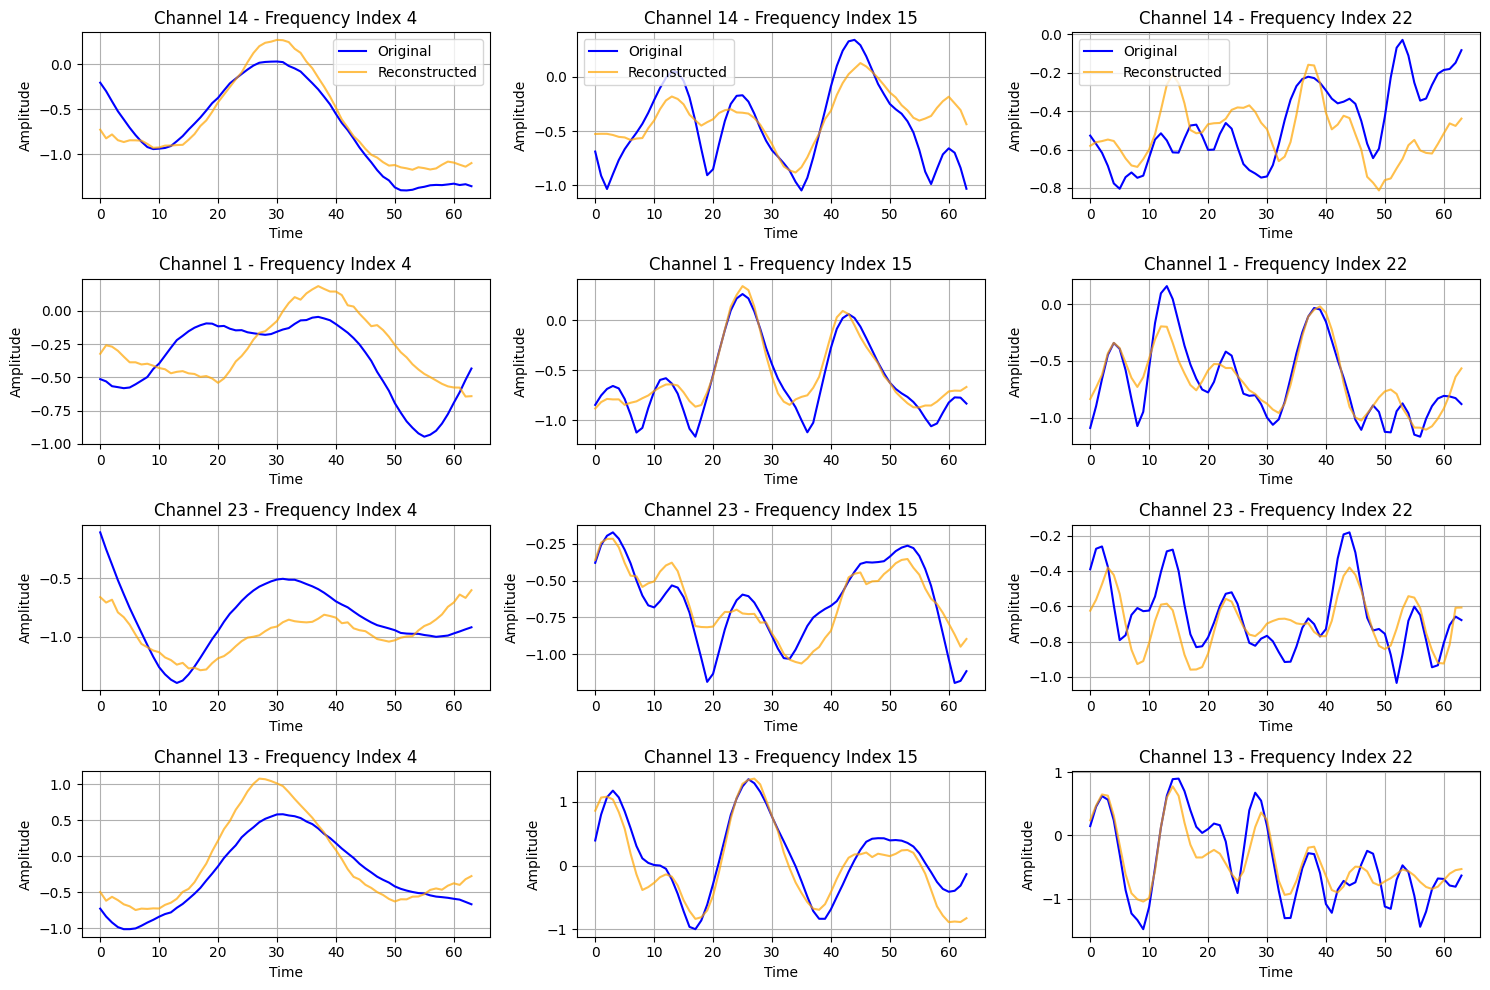

In [17]:
from packages.plotting.reconstruction_plots import plot_reconstruction_slices
import numpy as np

import torch
from packages.plotting.reconstruction_plots import plot_reconstruction_scatter

# --- Load model and parameters ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
#model.load_state_dict(torch.load("/kaggle/working/MIEEG/model_backups/best_model_epoch_25.pt", map_location="cpu"))
model.eval()
# --- Prepare input data ---
input_data = next(iter(val_loader))  # Replace with your actual input
input_data = input_data.to(device)
# --- Get reconstruction ---
with torch.no_grad():
    reconstructed = model(input_data)

# --- Plot reconstruction scatter ---
plot_reconstruction_scatter(input_data, reconstructed)

batch_size = config.get('batch_size', 31)
i = np.random.randint(0, batch_size)
if isinstance(reconstructed, tuple):
    reconstructed = reconstructed[0]
plot_reconstruction_slices(input_data[i,...], reconstructed[i,...], freqs=[4,15,22])